In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline  

%load_ext autoreload
%autoreload 2

# Playing Tennis with MADDPG

The solution I gave in [01-Playing-Tennis-with-DDPG](https://nbviewer.jupyter.org/github/bobflagg/Collaboration-and-Competition/blob/master/01-Playing-Tennis-with-DDPG.ipynb) to the [Tennis Environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) is simple, stable and achieves a pretty high average score but it is not very satisfying from a multi-agent reinforcement learning point of view.  In general it will not be possible to use the same model instance for all agents since different agents may need to achieve different goals. In this notebook I address that shortcoming by adapting DDPG to the multi-agent setting as in the paper [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/abs/1706.02275) (MADDPG). As illustrated in the figure below, the key idea of MADDPG is to use  **centralized critics**, which observe all states and actions, and **decentralized actors**, which only observe their own state.

![caption](./report/multi-agent-actor-critic.png)

## The Environment

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="../Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Training

In [5]:
from collections import deque
from maddpg import MADDPG
import numpy as np
import random
import torch

In [6]:
def train(env, agent, n_episodes=150, max_t=925, print_every=100):
    best_average_score = 0.0
    scores_deque = deque(maxlen=print_every)
    scores = []
    averaged_scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(2)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            score += rewards
            agent.add(states, actions, rewards, next_states, dones)
            if t % UPDATE_EVERY == 0:
                for j in range(N_UPDATES): agent.update()
            states = next_states
            if np.any(dones): break
        score = np.max(score)
        scores_deque.append(score)
        scores.append(score)
        if i_episode >= 100:
            data = np.array(scores[i_episode - 100:i_episode])
            averaged_scores.append(np.mean(data))
        else: averaged_scores.append(0.0)
            
        average_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
    return scores, averaged_scores



In [7]:
SEED = 6543
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

UPDATE_EVERY = 5
N_UPDATES = 30
n_episodes=900
max_t=1000
agent = MADDPG(state_size=state_size, action_size=action_size, seed=SEED) # 9876, 8765
scores, averaged_scores = train(env, agent, n_episodes=n_episodes, max_t=max_t)
print("\n")

Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.08
Episode 400	Average Score: 0.10
Episode 500	Average Score: 0.10
Episode 600	Average Score: 0.15
Episode 700	Average Score: 0.33
Episode 800	Average Score: 0.52
Episode 900	Average Score: 0.45




It's not really surprising that this approach does not do nearly as well as self-playing DDPG because it does not take advantage of special features of the Tennis environment but the average score did reach 0.52 so it is a solution.  

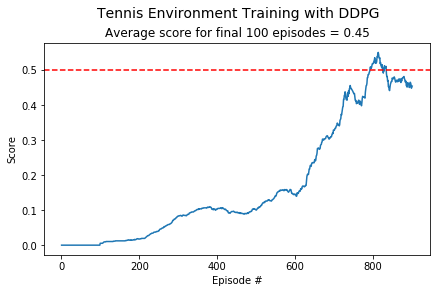

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
#pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), averaged_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(scores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14);

